In [1]:
import sys
sys.path.append("crypto-volatility-lab")

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from crypto_volatility_lab.modeling import LSTMGRUPipeline, TCNNPipeline, GRUPipeline, LSTMPipeline
from crypto_volatility_lab.data_construction import CryptoScraper, FeaturesCreator, TimeSeriesCreator
from crypto_volatility_lab.portfolio_optimization.portfolioConstructor import PortfolioConstructor
import pandas as pd

In [2]:
currency_list = ['BTC-USD', 'ETH-USD', 'LTC-USD']
test_start_date = datetime.strptime('2023-01-01', "%Y-%m-%d")

# Récupération des données

On va scraper les données de Yahoo Finance. L'objet CryptoScraper nous permet de réaliser cela. L'objet prend par défaut le maximum de l'historique jusqu'à la date d'aujourd'hui.

In [3]:
crypto_scraper = CryptoScraper()

In [4]:
ethereum_data = crypto_scraper.get_data_for_currency('ETH-USD')

In [5]:
# Exemple de données
ethereum_data.head()

,Date,Open,High,Low,Close,Adj,Volume
0,2025-01-24,3338.57,3409.54,3278.60,3404.13,3404.13,36143685632
1,2025-01-23,3240.48,3346.73,3184.07,3334.71,3334.71,32419520084
2,2025-01-22,3327.24,3364.75,3223.39,3240.22,3240.22,22171220981
3,2025-01-21,3278.44,3365.78,3202.49,3327.41,3327.41,32804001146
4,2025-01-20,3208.93,3444.28,3147.52,3278.04,3278.04,52383187336


# Création des time series

In [6]:
ts_creator = TimeSeriesCreator(data=ethereum_data, date_column_name='Date', value_column_name='Close')
ethereum_data["Log Returns"] = ts_creator.create_log_return_time_series()
ethereum_data["Volatility"] = ts_creator.create_volatility_time_series()

# Exemple de données
ethereum_data.head()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility
2633,2017-11-09,308.64,329.45,307.06,320.88,320.88,893249984,NaN,NaN
2632,2017-11-10,320.67,324.72,294.54,299.25,299.25,885985984,-0.069788,NaN
2631,2017-11-11,298.59,319.45,298.19,314.68,314.68,842300992,0.050277,NaN
2630,2017-11-12,314.69,319.15,298.51,307.91,307.91,1613479936,-0.021749,NaN
2629,2017-11-13,307.02,328.42,307.02,316.72,316.72,1041889984,0.028211,NaN


In [7]:
print(ethereum_data.shape)
ethereum_data.dropna(inplace=True)
print(ethereum_data.shape)

(2634, 9)
(2613, 9)


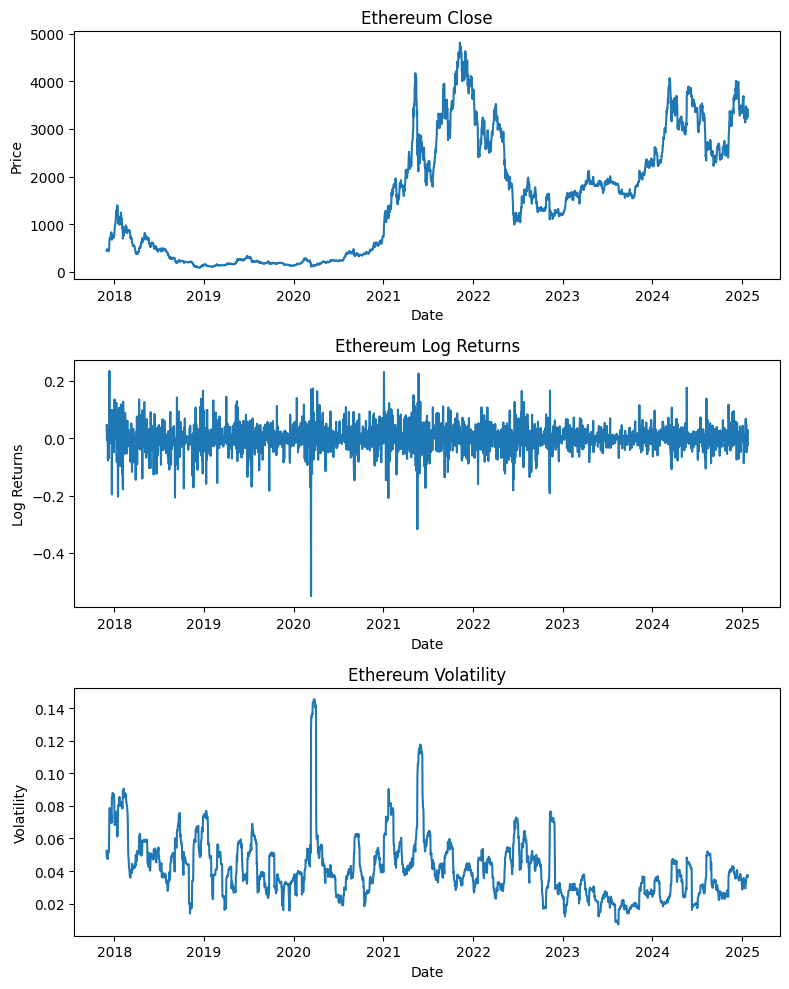

In [8]:
metrics = [
    ("Close", "Price"),
    ("Log Returns", "Log Returns"),
    ("Volatility", "Volatility"),
]

fig, ax = plt.subplots(len(metrics), 1, figsize=(8, 10))

for row, (metric, ylabel) in enumerate(metrics):
    ax[row].plot(ethereum_data["Date"], ethereum_data[metric])
    ax[row].set_title(f"Ethereum {metric}")
    ax[row].set_xlabel("Date")
    ax[row].set_ylabel(ylabel)

plt.tight_layout()
plt.show()


# Feature engineering

In [9]:
features_creator_ethereum = FeaturesCreator(data=ethereum_data)

features_creator_ethereum.create_all_features()

ethereum_data = features_creator_ethereum.transformed_data

features = features_creator_ethereum.features_names

# Exemple de données
ethereum_data.head()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility,Weekly Volatility,Monthly Volatility,Log Trading Range,Log Volume Change
2612,2017-11-30,431.21,465.50,401.24,447.11,447.11,1903040000,0.044804,0.052388,0.052388,0.052388,0.148552,NaN
2611,2017-12-01,445.21,472.61,428.31,466.54,466.54,1247879936,0.042539,0.048826,0.050607,0.050607,0.098423,-0.422007
2610,2017-12-02,466.85,476.24,456.65,463.45,463.45,943649984,-0.006645,0.048707,0.049974,0.049974,0.042005,-0.279446
2609,2017-12-03,463.70,482.81,451.85,465.85,465.85,990556992,0.005165,0.047945,0.049466,0.049466,0.066273,0.048512
2608,2017-12-04,466.05,474.78,453.31,470.20,470.20,1005550016,0.009294,0.047955,0.049164,0.049164,0.046275,0.015023


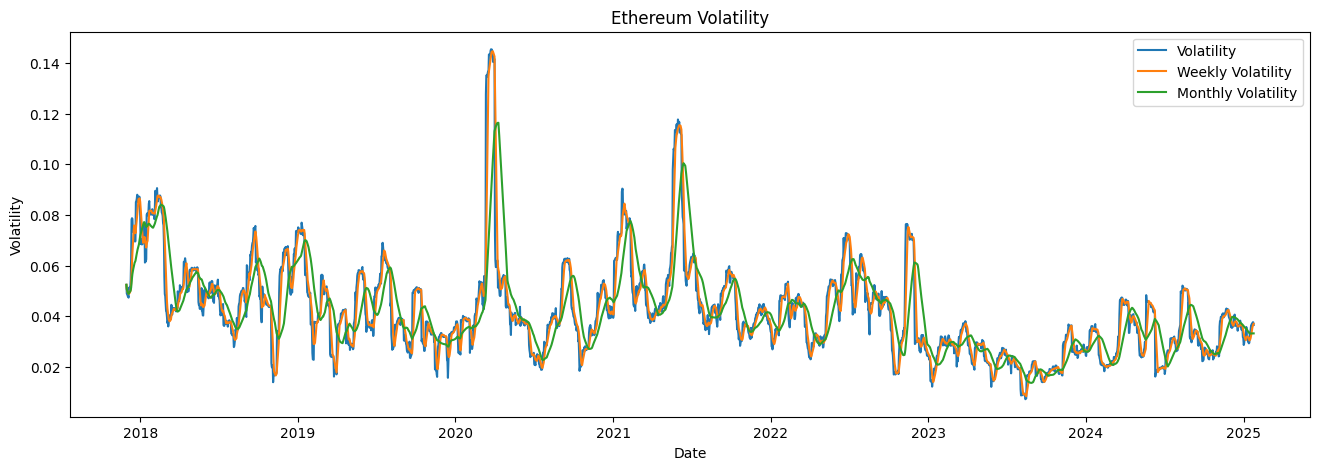

In [10]:
# plot volatility, weekly volatility, monthly volatility on the same plot
plt.figure(figsize=(16, 5))
plt.plot(ethereum_data["Date"], ethereum_data["Volatility"], label="Volatility")
plt.plot(ethereum_data["Date"], ethereum_data["Weekly Volatility"], label="Weekly Volatility")
plt.plot(ethereum_data["Date"], ethereum_data["Monthly Volatility"], label="Monthly Volatility")
plt.title("Ethereum Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

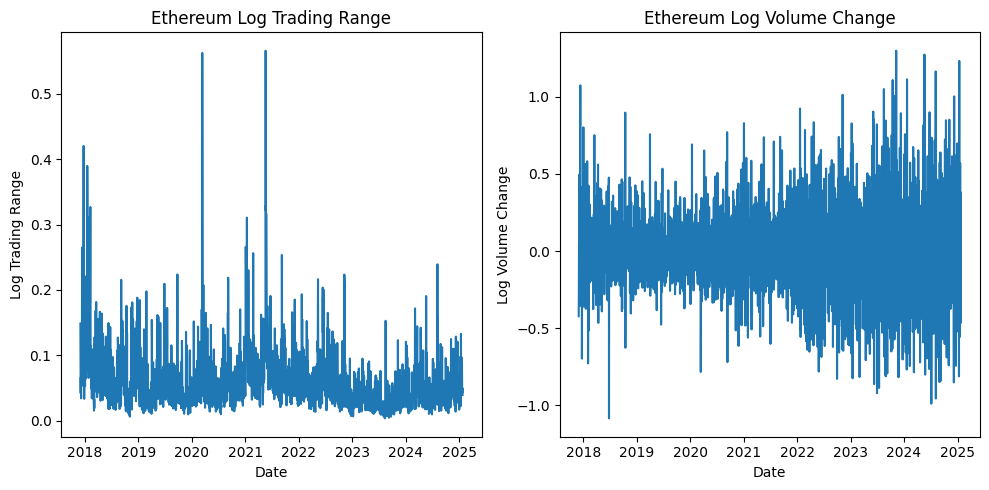

In [11]:
# plot log trading range and log volume change for bitcoin 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(ethereum_data["Date"], ethereum_data["Log Trading Range"])
ax[0].set_title("Ethereum Log Trading Range")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Log Trading Range")
ax[1].plot(ethereum_data["Date"], ethereum_data["Log Volume Change"])
ax[1].set_title("Ethereum Log Volume Change")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log Volume Change")
plt.tight_layout()
plt.show()

In [12]:
# # plot garch volatility, realized volatility on the same plot for the 3 cryptocurrencies subplots
# fig, ax = plt.subplots(3, 1, figsize=(13, 5))

# ax[0].plot(bitcoin_data["Date"], bitcoin_data["Volatility"], label="Volatility")
# ax[0].plot(bitcoin_data["Date"], bitcoin_data["GARCH Volatility"], label="GARCH Volatility")
# ax[0].set_title("Bitcoin Volatility")
# ax[0].set_xlabel("Date")
# ax[0].set_ylabel("Volatility")
# ax[0].legend()

# ax[1].plot(ethereum_data["Date"], ethereum_data["Volatility"], label="Volatility")
# ax[1].plot(ethereum_data["Date"], ethereum_data["GARCH Volatility"], label="GARCH Volatility")
# ax[1].set_title("Ethereum Volatility")
# ax[1].set_xlabel("Date")
# ax[1].set_ylabel("Volatility")
# ax[1].legend()

# ax[2].plot(litecoin_data["Date"], litecoin_data["Volatility"], label="Volatility")
# ax[2].plot(litecoin_data["Date"], litecoin_data["GARCH Volatility"], label="GARCH Volatility")
# ax[2].set_title("Litecoin Volatility")
# ax[2].set_xlabel("Date")
# ax[2].set_ylabel("Volatility")
# ax[2].legend()

# plt.tight_layout()
# plt.show()

# Train/test split

In [13]:
ethereum_data.dropna(inplace=True)

In [14]:

ethereum_train_data = ethereum_data[ethereum_data['Date'] < test_start_date]
ethereum_test_data = ethereum_data[ethereum_data['Date'] >= test_start_date]

# check proportion of test data
print(f"Ethereum test data proportion: {round(len(ethereum_test_data) / len(ethereum_data)*100, 2)}%")


Ethereum test data proportion: 28.91%


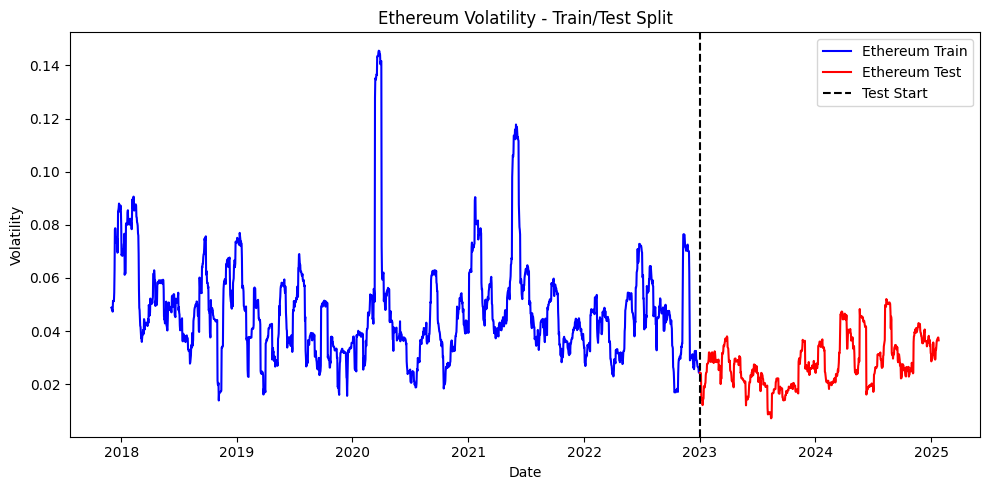

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(ethereum_train_data["Date"], ethereum_train_data["Volatility"], label="Ethereum Train", color="blue")
ax.plot(ethereum_test_data["Date"], ethereum_test_data["Volatility"], label="Ethereum Test", color="red")
ax.axvline(test_start_date, color="black", linestyle="--", label="Test Start")
ax.set_title("Ethereum Volatility - Train/Test Split")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()

plt.tight_layout()
plt.show()


# Prédiction de la volatilité

In [16]:
features = features_creator_ethereum.features_names
features

['Volatility',
 'Weekly Volatility',
 'Monthly Volatility',
 'Log Trading Range',
 'Log Volume Change']

In [17]:
# ethereum model
ethereum_pipeline = GRUPipeline(forecast_horizon=5, epochs=5, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))

Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0206 - val_loss: 0.0041
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0036 - val_loss: 0.0050


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


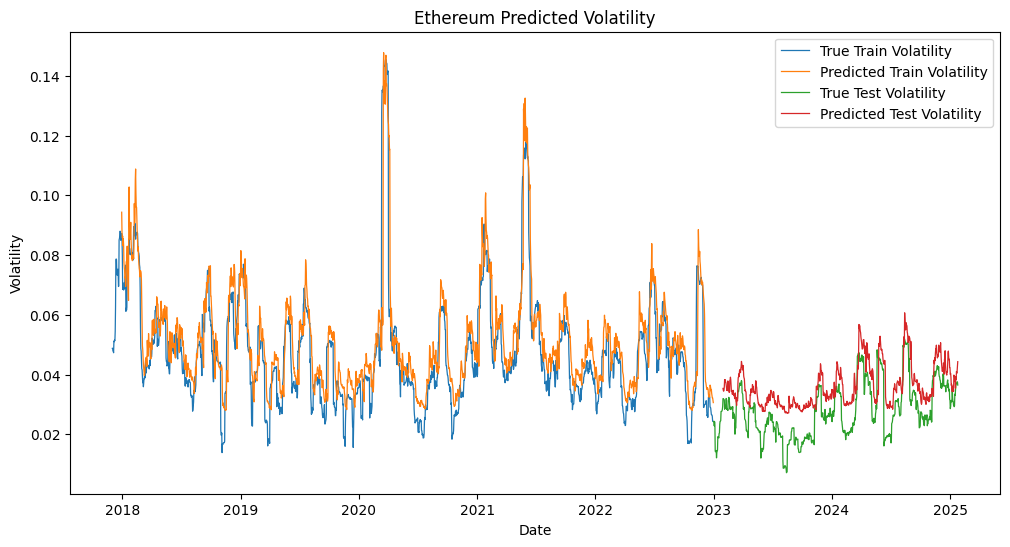

In [18]:
def predict_and_plot_ethereum(pipeline, train_data, test_data):
    y_pred_train = pipeline.predict(train_data[features].values)[:, 4]
    y_pred_test = pipeline.predict(test_data[features].values)[:, 4]
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_data["Date"], train_data["Volatility"], label="True Train Volatility", linewidth=0.9)
    plt.plot(train_data["Date"][-len(y_pred_train):], y_pred_train, label="Predicted Train Volatility", linewidth=0.9)
    plt.plot(test_data["Date"], test_data["Volatility"], label="True Test Volatility", linewidth=0.9)
    plt.plot(test_data["Date"][-len(y_pred_test):], y_pred_test, label="Predicted Test Volatility", linewidth=0.9)

    plt.title("Ethereum Predicted Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()

predict_and_plot_ethereum(ethereum_pipeline, ethereum_train_data, ethereum_test_data)


In [19]:
from typing import Tuple, Optional
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from abc import ABC, abstractmethod

In [22]:
# Liste des valeurs de lookback à tester
lookback_values = [30,31,32]

# Dictionnaire pour stocker les résultats
results = {}

for lookback in lookback_values:
    print(f"\n=== Test avec lookback={lookback} ===")
    
    # Instancier le pipeline avec la valeur actuelle de lookback
    ethereum_pipeline = GRUPipeline(
        lookback=lookback,
        forecast_horizon=5,  # Fixé à 5
        learning_rate=0.01,  # Fixé à 0.01 pour cet exemple
        epochs=5,  # Fixé à 5 pour cet exemple
        batch_size=32,  # Fixé à 32 pour cet exemple
        validation_split=0.1,  # Fixé à 0.1 pour cet exemple
        dropout_rate=0,  # Fixé à 0 pour cet exemple
        normalize=True,
        random_seed=42,
    )
    
    try:
        # Entraîner le modèle
        ethereum_pipeline.fit(
            ethereum_train_data[features].values,
            ethereum_train_data["Volatility"].values.astype(np.float64),
        )
        
        # Évaluer le modèle sur les données de test
        metrics = ethereum_pipeline.evaluate_metrics(
            ethereum_test_data[features].values,
            ethereum_test_data["Volatility"].values.astype(np.float64),
        )
        
        # Stocker les résultats
        if metrics:  # Vérifie que metrics n'est pas None
            results[lookback] = metrics
            print(f"Résultats pour lookback={lookback}: {metrics['overall']}")
        else:
            print(f"Erreur : metrics est vide pour lookback={lookback}")
    except Exception as e:
        print(f"Erreur lors du traitement de lookback={lookback} : {e}")

# Afficher les résultats pour chaque valeur de lookback
print("\n=== Résultats finaux ===")
for lookback, metrics in results.items():
    overall_metrics = metrics["overall"]
    print(f"\nRésultats pour lookback={lookback}:")
    print(f"  Overall MSE: {overall_metrics['mse']:.4f}")
    print(f"  Overall RMSE: {overall_metrics['rmse']:.4f}")
    print(f"  Overall MAE: {overall_metrics['mae']:.4f}")
    print(f"  Overall MAPE: {overall_metrics['mape']:.4f}%")

# Afficher les métriques par horizon (optionnel)
print("\n=== Détails des métriques par horizon ===")
for lookback, metrics in results.items():
    by_horizon_metrics = metrics["by_horizon"]
    print(f"\nMétriques par horizon pour lookback={lookback}:")
    print(f"  MSE: {by_horizon_metrics['mse']}")
    print(f"  RMSE: {by_horizon_metrics['rmse']}")
    print(f"  MAE: {by_horizon_metrics['mae']}")
    print(f"  MAPE: {by_horizon_metrics['mape']}")



=== Test avec lookback=30 ===
Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0219 - val_loss: 0.0041
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029 - val_loss: 0.0034

Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
------------------------------------------------------------
1         0.0000         0.0037         0.0026         12.9208        
2         0.0000         0.0041         0.0030         13.8705        
3         0.0000         0.0050         0.0036         17.8238        
4         0.0000         0.0052         0.0039         18.3564        
5         0.0000         0.0057         0.0044         20.5812        

Overall Evaluation Metrics:

In [23]:
# Liste des valeurs de learning_rate à tester
learning_rate_values = [0.001, 0.01, 0.1, 0.5]

# Dictionnaire pour stocker les résultats
results = {}

for learning_rate in learning_rate_values:
    print(f"\n=== Test avec learning_rate={learning_rate} ===")
    
    # Instancier le pipeline avec le learning_rate courant et lookback fixé à 30
    ethereum_pipeline = GRUPipeline(
        lookback=30,  # Fixé à 30
        forecast_horizon=5,  # Fixé à 5
        learning_rate=learning_rate,  # Variable testée
        epochs=5,  # Fixé à 5 pour cet exemple
        batch_size=32,  # Fixé à 32 pour cet exemple
        validation_split=0.1,  # Fixé à 0.1 pour cet exemple
        dropout_rate=0,  # Fixé à 0 pour cet exemple
        normalize=True,
        random_seed=42,
    )
    
    try:
        # Entraîner le modèle
        ethereum_pipeline.fit(
            ethereum_train_data[features].values,
            ethereum_train_data["Volatility"].values.astype(np.float64),
        )
        
        # Évaluer le modèle sur les données de test
        metrics = ethereum_pipeline.evaluate_metrics(
            ethereum_test_data[features].values,
            ethereum_test_data["Volatility"].values.astype(np.float64),
        )
        
        # Stocker les résultats
        if metrics:  # Vérifie que metrics n'est pas None
            results[learning_rate] = metrics
            print(f"Résultats pour learning_rate={learning_rate}: {metrics['overall']}")
        else:
            print(f"Erreur : metrics est vide pour learning_rate={learning_rate}")
    except Exception as e:
        print(f"Erreur lors du traitement de learning_rate={learning_rate} : {e}")

# Afficher les résultats pour chaque valeur de learning_rate
print("\n=== Résultats finaux ===")
for learning_rate, metrics in results.items():
    overall_metrics = metrics["overall"]
    print(f"\nRésultats pour learning_rate={learning_rate}:")
    print(f"  Overall MSE: {overall_metrics['mse']:.4f}")
    print(f"  Overall RMSE: {overall_metrics['rmse']:.4f}")
    print(f"  Overall MAE: {overall_metrics['mae']:.4f}")
    print(f"  Overall MAPE: {overall_metrics['mape']:.4f}%")

# Afficher les métriques par horizon (optionnel)
print("\n=== Détails des métriques par horizon ===")
for learning_rate, metrics in results.items():
    by_horizon_metrics = metrics["by_horizon"]
    print(f"\nMétriques par horizon pour learning_rate={learning_rate}:")
    print(f"  MSE: {by_horizon_metrics['mse']}")
    print(f"  RMSE: {by_horizon_metrics['rmse']}")
    print(f"  MAE: {by_horizon_metrics['mae']}")
    print(f"  MAPE: {by_horizon_metrics['mape']}")



=== Test avec learning_rate=0.001 ===
Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0459 - val_loss: 0.0094
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0034 - val_loss: 0.0040

Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
------------------------------------------------------------
1         0.0000         0.0044         0.0034         16.3362        
2         0.0000         0.0044         0.0033         15.3397        
3         0.0000         0.0048         0.0037         16.9468        
4         0.0001         0.0078         0.0065         30.9092        
5         0.0000         0.0067         0.0055         25.4754        

Overall Evaluation 

In [24]:
# Liste des valeurs d'epochs à tester
epochs_values = [5, 10, 20, 30]

# Dictionnaire pour stocker les résultats
results = {}

for epochs in epochs_values:
    print(f"\n=== Test avec epochs={epochs} ===")
    
    # Instancier le pipeline avec epochs courant, learning_rate=0.01 et lookback fixé à 30
    ethereum_pipeline = GRUPipeline(
        lookback=30,  # Fixé à 30
        forecast_horizon=5,  # Fixé à 5
        learning_rate=0.01,  # Fixé à 0.01
        epochs=epochs,  # Variable testée
        batch_size=32,  # Fixé à 32 pour cet exemple
        validation_split=0.1,  # Fixé à 0.1 pour cet exemple
        dropout_rate=0,  # Fixé à 0 pour cet exemple
        normalize=True,
        random_seed=42,
    )
    
    try:
        # Entraîner le modèle
        ethereum_pipeline.fit(
            ethereum_train_data[features].values,
            ethereum_train_data["Volatility"].values.astype(np.float64),
        )
        
        # Évaluer le modèle sur les données de test
        metrics = ethereum_pipeline.evaluate_metrics(
            ethereum_test_data[features].values,
            ethereum_test_data["Volatility"].values.astype(np.float64),
        )
        
        # Stocker les résultats
        if metrics:  # Vérifie que metrics n'est pas None
            results[epochs] = metrics
            print(f"Résultats pour epochs={epochs}: {metrics['overall']}")
        else:
            print(f"Erreur : metrics est vide pour epochs={epochs}")
    except Exception as e:
        print(f"Erreur lors du traitement de epochs={epochs} : {e}")

# Afficher les résultats pour chaque valeur de epochs
print("\n=== Résultats finaux ===")
for epochs, metrics in results.items():
    overall_metrics = metrics["overall"]
    print(f"\nRésultats pour epochs={epochs}:")
    print(f"  Overall MSE: {overall_metrics['mse']:.4f}")
    print(f"  Overall RMSE: {overall_metrics['rmse']:.4f}")
    print(f"  Overall MAE: {overall_metrics['mae']:.4f}")
    print(f"  Overall MAPE: {overall_metrics['mape']:.4f}%")

# Afficher les métriques par horizon (optionnel)
print("\n=== Détails des métriques par horizon ===")
for epochs, metrics in results.items():
    by_horizon_metrics = metrics["by_horizon"]
    print(f"\nMétriques par horizon pour epochs={epochs}:")
    print(f"  MSE: {by_horizon_metrics['mse']}")
    print(f"  RMSE: {by_horizon_metrics['rmse']}")
    print(f"  MAE: {by_horizon_metrics['mae']}")
    print(f"  MAPE: {by_horizon_metrics['mape']}")



=== Test avec epochs=5 ===
Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0219 - val_loss: 0.0041
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0029 - val_loss: 0.0034

Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
------------------------------------------------------------
1         0.0000         0.0037         0.0026         12.9208        
2         0.0000         0.0041         0.0030         13.8705        
3         0.0000         0.0050         0.0036         17.8238        
4         0.0000         0.0052         0.0039         18.3564        
5         0.0000         0.0057         0.0044         20.5812        

Overall Evaluation Metrics:
--

In [25]:
# Liste des valeurs de batch_size à tester
batch_size_values = [16, 32, 64, 128]

# Dictionnaire pour stocker les résultats
results = {}

for batch_size in batch_size_values:
    print(f"\n=== Test avec batch_size={batch_size} ===")
    
    # Instancier le pipeline avec batch_size courant, epochs=5, learning_rate=0.01, et lookback fixé à 30
    ethereum_pipeline = GRUPipeline(
        lookback=30,  # Fixé à 30
        forecast_horizon=5,  # Fixé à 5
        learning_rate=0.01,  # Fixé à 0.01
        epochs=5,  # Fixé à 5
        batch_size=batch_size,  # Variable testée
        validation_split=0.1,  # Fixé à 0.1 pour cet exemple
        dropout_rate=0,  # Fixé à 0 pour cet exemple
        normalize=True,
        random_seed=42,
    )
    
    try:
        # Entraîner le modèle
        ethereum_pipeline.fit(
            ethereum_train_data[features].values,
            ethereum_train_data["Volatility"].values.astype(np.float64),
        )
        
        # Évaluer le modèle sur les données de test
        metrics = ethereum_pipeline.evaluate_metrics(
            ethereum_test_data[features].values,
            ethereum_test_data["Volatility"].values.astype(np.float64),
        )
        
        # Stocker les résultats
        if metrics:  # Vérifie que metrics n'est pas None
            results[batch_size] = metrics
            print(f"Résultats pour batch_size={batch_size}: {metrics['overall']}")
        else:
            print(f"Erreur : metrics est vide pour batch_size={batch_size}")
    except Exception as e:
        print(f"Erreur lors du traitement de batch_size={batch_size} : {e}")

# Afficher les résultats pour chaque valeur de batch_size
print("\n=== Résultats finaux ===")
for batch_size, metrics in results.items():
    overall_metrics = metrics["overall"]
    print(f"\nRésultats pour batch_size={batch_size}:")
    print(f"  Overall MSE: {overall_metrics['mse']:.4f}")
    print(f"  Overall RMSE: {overall_metrics['rmse']:.4f}")
    print(f"  Overall MAE: {overall_metrics['mae']:.4f}")
    print(f"  Overall MAPE: {overall_metrics['mape']:.4f}%")

# Afficher les métriques par horizon (optionnel)
print("\n=== Détails des métriques par horizon ===")
for batch_size, metrics in results.items():
    by_horizon_metrics = metrics["by_horizon"]
    print(f"\nMétriques par horizon pour batch_size={batch_size}:")
    print(f"  MSE: {by_horizon_metrics['mse']}")
    print(f"  RMSE: {by_horizon_metrics['rmse']}")
    print(f"  MAE: {by_horizon_metrics['mae']}")
    print(f"  MAPE: {by_horizon_metrics['mape']}")



=== Test avec batch_size=16 ===
Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0156 - val_loss: 0.0039
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0030 - val_loss: 0.0037

Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
------------------------------------------------------------
1         0.0000         0.0045         0.0033         16.1980        
2         0.0000         0.0049         0.0036         17.5835        
3         0.0000         0.0059         0.0043         21.7919        
4         0.0000         0.0059         0.0045         21.6138        
5         0.0000         0.0065         0.0050         24.4741        

Overall Evalua

In [26]:
# Liste des valeurs de validation_split à tester
validation_split_values = [0.1, 0.2, 0.3, 0.4]

# Dictionnaire pour stocker les résultats
results = {}

for validation_split in validation_split_values:
    print(f"\n=== Test avec validation_split={validation_split} ===")
    
    # Instancier le pipeline avec validation_split courant, batch_size=32, epochs=5, learning_rate=0.01, et lookback fixé à 30
    ethereum_pipeline = GRUPipeline(
        lookback=30,  # Fixé à 30
        forecast_horizon=5,  # Fixé à 5
        learning_rate=0.01,  # Fixé à 0.01
        epochs=5,  # Fixé à 5
        batch_size=32,  # Fixé à 32
        validation_split=validation_split,  # Variable testée
        dropout_rate=0,  # Fixé à 0 pour cet exemple
        normalize=True,
        random_seed=42,
    )
    
    try:
        # Entraîner le modèle
        ethereum_pipeline.fit(
            ethereum_train_data[features].values,
            ethereum_train_data["Volatility"].values.astype(np.float64),
        )
        
        # Évaluer le modèle sur les données de test
        metrics = ethereum_pipeline.evaluate_metrics(
            ethereum_test_data[features].values,
            ethereum_test_data["Volatility"].values.astype(np.float64),
        )
        
        # Stocker les résultats
        if metrics:  # Vérifie que metrics n'est pas None
            results[validation_split] = metrics
            print(f"Résultats pour validation_split={validation_split}: {metrics['overall']}")
        else:
            print(f"Erreur : metrics est vide pour validation_split={validation_split}")
    except Exception as e:
        print(f"Erreur lors du traitement de validation_split={validation_split} : {e}")

# Afficher les résultats pour chaque valeur de validation_split
print("\n=== Résultats finaux ===")
for validation_split, metrics in results.items():
    overall_metrics = metrics["overall"]
    print(f"\nRésultats pour validation_split={validation_split}:")
    print(f"  Overall MSE: {overall_metrics['mse']:.4f}")
    print(f"  Overall RMSE: {overall_metrics['rmse']:.4f}")
    print(f"  Overall MAE: {overall_metrics['mae']:.4f}")
    print(f"  Overall MAPE: {overall_metrics['mape']:.4f}%")

# Afficher les métriques par horizon (optionnel)
print("\n=== Détails des métriques par horizon ===")
for validation_split, metrics in results.items():
    by_horizon_metrics = metrics["by_horizon"]
    print(f"\nMétriques par horizon pour validation_split={validation_split}:")
    print(f"  MSE: {by_horizon_metrics['mse']}")
    print(f"  RMSE: {by_horizon_metrics['rmse']}")
    print(f"  MAE: {by_horizon_metrics['mae']}")
    print(f"  MAPE: {by_horizon_metrics['mape']}")



=== Test avec validation_split=0.1 ===
Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0219 - val_loss: 0.0041
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0029 - val_loss: 0.0034

Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
------------------------------------------------------------
1         0.0000         0.0037         0.0026         12.9208        
2         0.0000         0.0041         0.0030         13.8705        
3         0.0000         0.0050         0.0036         17.8238        
4         0.0000         0.0052         0.0039         18.3564        
5         0.0000         0.0057         0.0044         20.5812        

Overall Evaluatio

In [27]:
# Liste des valeurs de dropout_rate à tester
dropout_rate_values = [0.0, 0.1, 0.2, 0.3, 0.5]

# Dictionnaire pour stocker les résultats
results = {}

for dropout_rate in dropout_rate_values:
    print(f"\n=== Test avec dropout_rate={dropout_rate} ===")
    
    # Instancier le pipeline avec dropout_rate courant, validation_split=0.1, batch_size=32, epochs=5, learning_rate=0.01, et lookback fixé à 30
    ethereum_pipeline = GRUPipeline(
        lookback=30,  # Fixé à 30
        forecast_horizon=5,  # Fixé à 5
        learning_rate=0.01,  # Fixé à 0.01
        epochs=5,  # Fixé à 5
        batch_size=32,  # Fixé à 32
        validation_split=0.1,  # Fixé à 0.1
        dropout_rate=dropout_rate,  # Variable testée
        normalize=True,
        random_seed=42,
    )
    
    try:
        # Entraîner le modèle
        ethereum_pipeline.fit(
            ethereum_train_data[features].values,
            ethereum_train_data["Volatility"].values.astype(np.float64),
        )
        
        # Évaluer le modèle sur les données de test
        metrics = ethereum_pipeline.evaluate_metrics(
            ethereum_test_data[features].values,
            ethereum_test_data["Volatility"].values.astype(np.float64),
        )
        
        # Stocker les résultats
        if metrics:  # Vérifie que metrics n'est pas None
            results[dropout_rate] = metrics
            print(f"Résultats pour dropout_rate={dropout_rate}: {metrics['overall']}")
        else:
            print(f"Erreur : metrics est vide pour dropout_rate={dropout_rate}")
    except Exception as e:
        print(f"Erreur lors du traitement de dropout_rate={dropout_rate} : {e}")

# Afficher les résultats pour chaque valeur de dropout_rate
print("\n=== Résultats finaux ===")
for dropout_rate, metrics in results.items():
    overall_metrics = metrics["overall"]
    print(f"\nRésultats pour dropout_rate={dropout_rate}:")
    print(f"  Overall MSE: {overall_metrics['mse']:.4f}")
    print(f"  Overall RMSE: {overall_metrics['rmse']:.4f}")
    print(f"  Overall MAE: {overall_metrics['mae']:.4f}")
    print(f"  Overall MAPE: {overall_metrics['mape']:.4f}%")

# Afficher les métriques par horizon (optionnel)
print("\n=== Détails des métriques par horizon ===")
for dropout_rate, metrics in results.items():
    by_horizon_metrics = metrics["by_horizon"]
    print(f"\nMétriques par horizon pour dropout_rate={dropout_rate}:")
    print(f"  MSE: {by_horizon_metrics['mse']}")
    print(f"  RMSE: {by_horizon_metrics['rmse']}")
    print(f"  MAE: {by_horizon_metrics['mae']}")
    print(f"  MAPE: {by_horizon_metrics['mape']}")



=== Test avec dropout_rate=0.0 ===
Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0219 - val_loss: 0.0041
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0029 - val_loss: 0.0034

Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
------------------------------------------------------------
1         0.0000         0.0037         0.0026         12.9208        
2         0.0000         0.0041         0.0030         13.8705        
3         0.0000         0.0050         0.0036         17.8238        
4         0.0000         0.0052         0.0039         18.3564        
5         0.0000         0.0057         0.0044         20.5812        

Overall Evaluation Met

In [ ]:
        lookback=30,  # Fixé à 30
        forecast_horizon=5,  # Fixé à 5
        learning_rate=0.01,  # Fixé à 0.01
        epochs=5,  # Fixé à 5
        batch_size=32,  # Fixé à 32
        validation_split=0.1,  # Fixé à 0.1
        dropout_rate=dropout_rate,  # Variable testée
        normalize=True,
        random_seed=42,

In [28]:
# ethereum model
ethereum_pipeline = GRUPipeline(lookback=30,learning_rate=0.01,forecast_horizon=5, epochs=5, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))

Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - loss: 0.0219 - val_loss: 0.0041
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0029 - val_loss: 0.0034


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


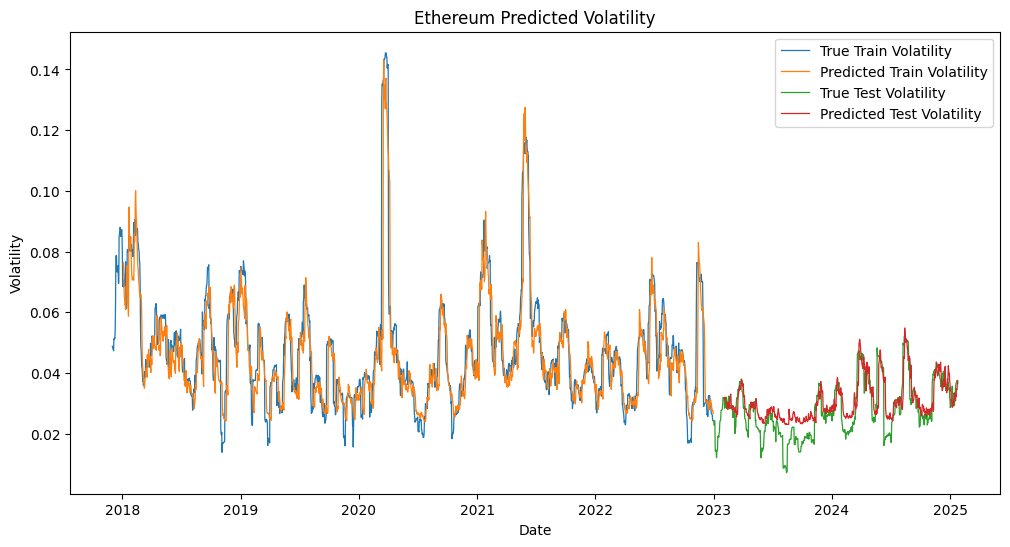

In [29]:
def predict_and_plot_ethereum(pipeline, train_data, test_data):
    y_pred_train = pipeline.predict(train_data[features].values)[:, 4]
    y_pred_test = pipeline.predict(test_data[features].values)[:, 4]
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_data["Date"], train_data["Volatility"], label="True Train Volatility", linewidth=0.9)
    plt.plot(train_data["Date"][-len(y_pred_train):], y_pred_train, label="Predicted Train Volatility", linewidth=0.9)
    plt.plot(test_data["Date"], test_data["Volatility"], label="True Test Volatility", linewidth=0.9)
    plt.plot(test_data["Date"][-len(y_pred_test):], y_pred_test, label="Predicted Test Volatility", linewidth=0.9)

    plt.title("Ethereum Predicted Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()

predict_and_plot_ethereum(ethereum_pipeline, ethereum_train_data, ethereum_test_data)
